The visualization used for this homework is based on Alexandr Verinov's code.  

# Generative models

In this homework we will try several criterions for learning an implicit model. Almost everything is written for you, and you only need to implement the objective for the game and play around with the model. 

**0)** Read the code

**1)** Implement objective for a vanilla [Generative Adversarial Networks](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf) (GAN). The hyperparameters are already set in the code. The model will converge if you implement the objective (1) right. 

**2)** Note the discussion in the paper, that the objective for $G$ can be of two kinds: $min_G log(1 - D)$ and $min_G - log(D)$. Implement the second objective and ensure model converges. Most likely, in this example you will not notice the difference, but people usually use the second objective, it really matters in more complicated scenarios.

**3 & 4)** Implement [Wasserstein GAN](https://arxiv.org/abs/1701.07875) ([WGAN](https://arxiv.org/abs/1704.00028)) and WGAN-GP. To make the discriminator have Lipschitz property you need to clip discriminator's weights to $[-0.01, 0.01]$ range (WGAN) or use gradient penalty (WGAN-GP). You will need to make few modifications to the code: 1) remove sigmoids from discriminator 2) add weight clipping clipping / gradient penaly. 3) change objective. See [implementation 1](https://github.com/martinarjovsky/WassersteinGAN/) / [implementation 2](https://github.com/caogang/wgan-gp). They also use different optimizer. The default hyperparameters may not work, spend time to tune them.

**5) Bonus: same thing without GANs** Implement maximum mean discrepancy estimator (MMD). MMD is discrepancy measure between distributions. In our case we use it to calculate discrepancy between real and fake data. You need to implement RBF kernel $k(x,x')=\exp \left(-{\frac  {1}{2\sigma ^{2}}}||x-x'||^{2}\right)$ and an MMD estimator (see eq.8 from https://arxiv.org/pdf/1505.03906.pdf). MMD is then used instead of discriminator.

In [1]:
#!g1.1
""" 
    Please, implement everything in one notebook, using if statements to switch between the tasks
"""
TASK = 1 # 2, 3, 4, 5

# Imports

In [2]:
#!g1.1
import numpy as np
import time
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(12345)
lims=(-5, 5)

# Define sampler from real data and Z 

In [3]:
#!g1.1
from scipy.stats import rv_discrete

MEANS = np.array(
        [[-1,-3],
         [1,3],
         [-2,0],
        ])
COVS = np.array(
        [[[1,0.8],[0.8,1]],
        [[1,-0.5],[-0.5,1]],
        [[1,0],[0,1]],
        ])
PROBS = np.array([
        0.2,
        0.5,
        0.3
        ])
assert len(MEANS) == len(COVS) == len(PROBS), "number of components mismatch"
COMPONENTS = len(MEANS)

comps_dist = rv_discrete(values=(range(COMPONENTS), PROBS))

def sample_true(N):
    comps = comps_dist.rvs(size=N)
    conds = np.arange(COMPONENTS)[:,None] == comps[None,:]
    arr = np.array([np.random.multivariate_normal(MEANS[c], COVS[c], size=N)
                     for c in range(COMPONENTS)])
    return np.select(conds[:,:,None], arr).astype(np.float32)

NOISE_DIM = 20
def sample_noise(N):
    return np.random.normal(size=(N,NOISE_DIM)).astype(np.float32)

# Visualization functions

In [4]:
#!g1.1
def vis_data(data):
    """
        Visualizes data as histogram
    """
    hist = np.histogram2d(data[:, 1], data[:, 0], bins=100, range=[lims, lims])
    plt.pcolormesh(hist[1], hist[2], hist[0], alpha=0.5)

fixed_noise = sample_noise(1000)
def vis_g():
    """
        Visualizes generator's samples as circles
    """
    data = generator(Variable(torch.Tensor(fixed_noise))).data.numpy()
    if np.isnan(data).any():
        return
    
    plt.scatter(data[:,0], data[:,1], alpha=0.2, c='b')
    plt.xlim(lims)
    plt.ylim(lims)
    
def vis_d():
    """
        Visualizes discriminator's gradient on grid
    """
    X, Y = np.meshgrid(np.linspace(lims[0], lims[1], 30), np.linspace(lims[0], lims[1], 30))
    X = X.flatten()
    Y = Y.flatten()
    grid = Variable(torch.Tensor(np.vstack([X, Y]).T), requires_grad=True)
    data_gen = generator(Variable(torch.Tensor(fixed_noise)))
    loss = d_loss(discriminator(data_gen), discriminator(grid))
    loss.backward()
    grads = - grid.grad.data.numpy()
    plt.quiver(X, Y, grads[:, 0], grads[:, 1], color='black',alpha=0.9)

# Define architectures

After you've passed task 1 you can play with architectures.

#### Generator

In [5]:
#!g1.1
class Generator(nn.Module):
    def __init__(self, noise_dim, out_dim, hidden_dim=100):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(noise_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        
        self.fc3 = nn.Linear(hidden_dim, out_dim)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.constant_(self.fc3.bias, 0.0)

    def forward(self, z):
        """
            Generator takes a vector of noise and produces sample
        """
        h1 = F.tanh(self.fc1(z))
        h2 = F.leaky_relu(self.fc2(h1))
        y_gen = self.fc3(h2)
        return y_gen

#### Discriminator

In [6]:
#!g1.1
class Discriminator(nn.Module):
    def __init__(self, in_dim, hidden_dim=100):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.constant_(self.fc3.bias, 0.0)
        
        self.fc4 = nn.Linear(hidden_dim, 1)
        nn.init.xavier_normal_(self.fc4.weight)
        nn.init.constant_(self.fc4.bias, 0.0)

    def forward(self, x):
        h1 = F.tanh(self.fc1(x))
        h2 = F.leaky_relu(self.fc2(h1))
        h3 = F.leaky_relu(self.fc3(h2))
        score = torch.sigmoid(self.fc4(h3))
        return score

# Define updates and losses

In [7]:
#!g1.1
generator = Generator(NOISE_DIM, out_dim = 2)
discriminator = Discriminator(in_dim = 2)

lr = 0.001

g_optimizer = optim.Adam(generator.parameters(),     lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

Notice we are using ADAM optimizer with `beta1=0.5` for both discriminator and discriminator. This is a common practice and works well. Motivation: models should be flexible and adapt itself rapidly to the distributions. 

You can try different optimizers and parameters.

In [8]:
#!g1.1
################################
# IMPLEMENT HERE
# Define the g_loss and d_loss here
# these are the only lines of code you need to change to implement GAN game

def g_loss(dis_fake):
    if TASK == 1: 
        g_loss = torch.log(1 - dis_fake).mean()
    elif TASK == 2:
        g_loss = -torch.log(dis_fake).mean()
    elif TASK == 3 or TASK == 4:
        g_loss = -torch.mean(dis_fake)
        
    return g_loss

def d_loss(dis_fake, dis_true, penalty=0.):
    if TASK == 1 or TASK == 2: 
        d_loss = -torch.log(dis_true).mean() - torch.log(1 - dis_fake).mean()
    elif TASK == 3:
        d_loss = -torch.mean(dis_true) + torch.mean(dis_fake)
    elif TASK == 4:
        d_loss = -torch.mean(dis_true) + torch.mean(dis_fake) + penalty

    return d_loss
################################

# Get real data

In [9]:
#!g1.1
data = sample_true(100000)
def iterate_minibatches(X, batchsize, y=None):
    perm = np.random.permutation(X.shape[0])
    
    for start in range(0, X.shape[0], batchsize):
        end = min(start + batchsize, X.shape[0])
        if y is None:
            yield X[perm[start:end]]
        else:
            yield X[perm[start:end]], y[perm[start:end]]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


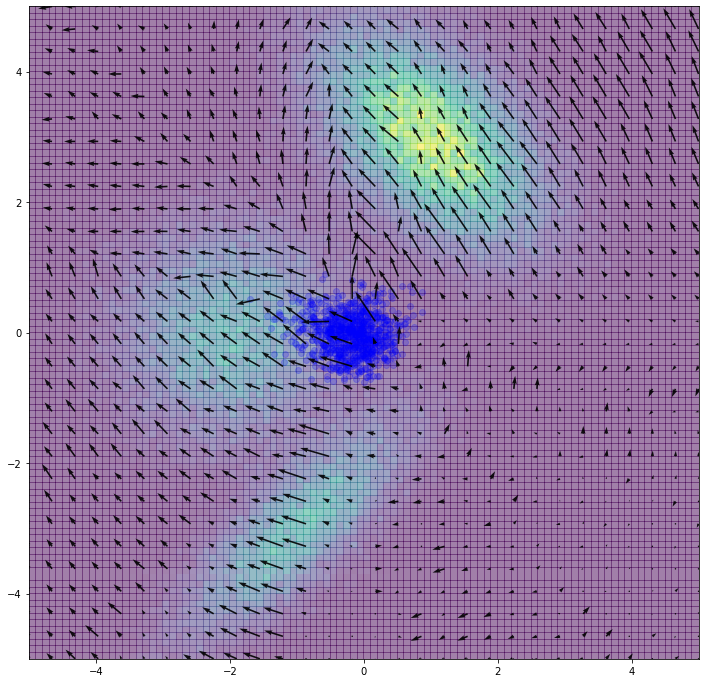

In [10]:
#!g1.1
plt.rcParams['figure.figsize'] = (12, 12)
vis_data(data)
vis_g()
vis_d()

**Legend**:
- Blue dots are generated samples. 
- Colored histogram at the back shows density of real data. 
- And with arrows we show gradients of the discriminator -- they are the directions that discriminator pushes generator's samples. 

# Train the model

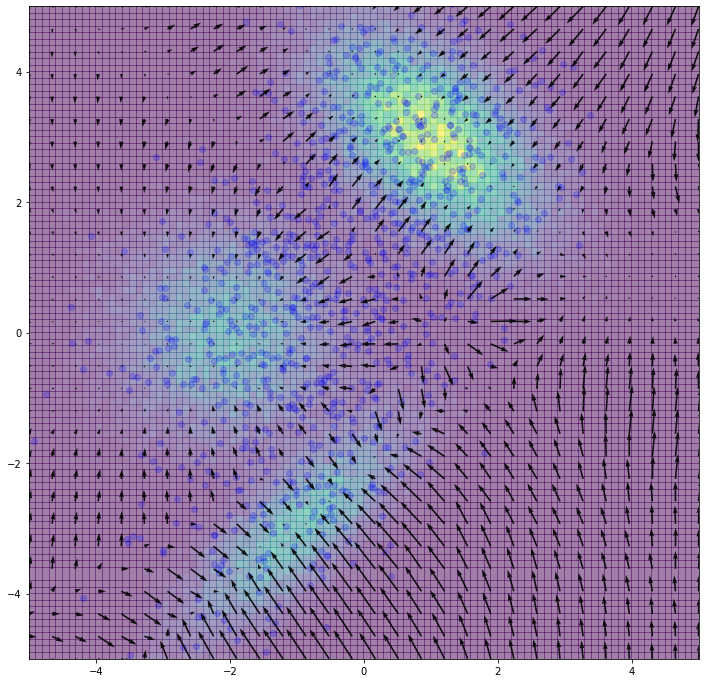

In [11]:
#!g1.1
from IPython import display

plt.xlim(lims)
plt.ylim(lims)

num_epochs = 100
batch_size = 64

# ===========================
# IMPORTANT PARAMETER:
# Number of D updates per G update
# ===========================
k_d, k_g = 4, 1

accs = []

try:
    for epoch in range(num_epochs):
        for input_data in iterate_minibatches(data, batch_size):
            
            # Optimize D
            for _ in range(k_d):
                # Sample noise
                noise = Variable(torch.Tensor(sample_noise(len(input_data))))
                
                # Do an update
                inp_data = Variable(torch.Tensor(input_data))
                data_gen = generator(noise)
                loss = d_loss(discriminator(data_gen), discriminator(inp_data))
                d_optimizer.zero_grad()
                loss.backward()
                d_optimizer.step()
    
            # Optimize G
            for _ in range(k_g):
                # Sample noise
                noise = Variable(torch.Tensor(sample_noise(len(input_data))))
                
                # Do an update
                data_gen = generator(noise)
                loss = g_loss(discriminator(data_gen))
                g_optimizer.zero_grad()
                loss.backward()
                g_optimizer.step()
            
            # Visualize
            plt.clf()
            vis_data(data); vis_g(); vis_d()
            display.clear_output(wait=True)
            display.display(plt.gcf())

        
except KeyboardInterrupt:
    pass

#### TASK 2

In [12]:
#!g1.1
TASK = 2

In [13]:
#!g1.1
generator = Generator(NOISE_DIM, out_dim = 2)
discriminator = Discriminator(in_dim = 2)

lr = 0.001

g_optimizer = optim.Adam(generator.parameters(),     lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

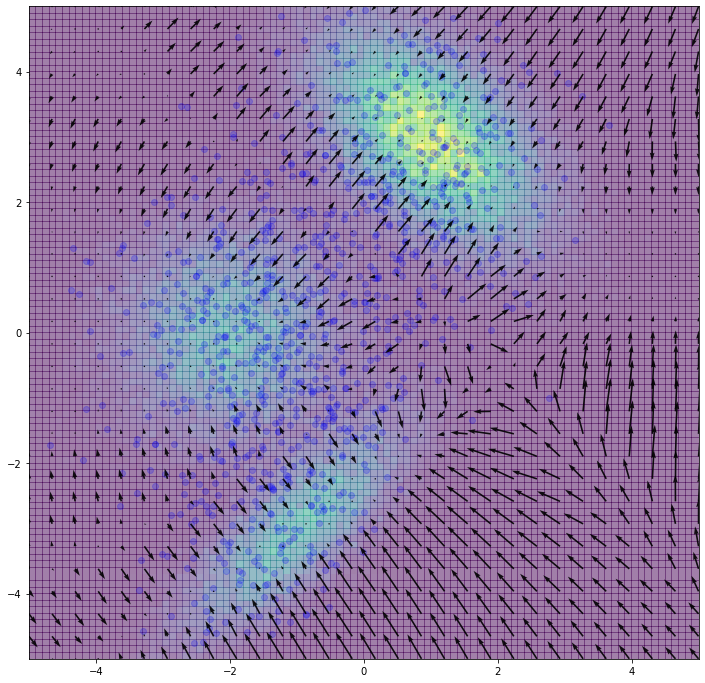

In [15]:
#!g1.1
from IPython import display

plt.xlim(lims)
plt.ylim(lims)

num_epochs = 100
batch_size = 64

# ===========================
# IMPORTANT PARAMETER:
# Number of D updates per G update
# ===========================
k_d, k_g = 4, 1

accs = []

try:
    for epoch in range(num_epochs):
        for input_data in iterate_minibatches(data, batch_size):
            
            # Optimize D
            for _ in range(k_d):
                # Sample noise
                noise = Variable(torch.Tensor(sample_noise(len(input_data))))
                
                # Do an update
                inp_data = Variable(torch.Tensor(input_data))
                data_gen = generator(noise)
                loss = d_loss(discriminator(data_gen), discriminator(inp_data))
                d_optimizer.zero_grad()
                loss.backward()
                d_optimizer.step()
    
            # Optimize G
            for _ in range(k_g):
                # Sample noise
                noise = Variable(torch.Tensor(sample_noise(len(input_data))))
                
                # Do an update
                data_gen = generator(noise)
                loss = g_loss(discriminator(data_gen))
                g_optimizer.zero_grad()
                loss.backward()
                g_optimizer.step()
            
            # Visualize
            plt.clf()
            vis_data(data); vis_g(); vis_d()
            display.clear_output(wait=True)
            display.display(plt.gcf())

        
except KeyboardInterrupt:
    pass

#### TASK 3

In [16]:
#!g1.1
TASK = 3

In [17]:
#!g1.1
class Discriminator(nn.Module):
    def __init__(self, in_dim, hidden_dim=100):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.constant_(self.fc3.bias, 0.0)
        
        self.fc4 = nn.Linear(hidden_dim, 1)
        nn.init.xavier_normal_(self.fc4.weight)
        nn.init.constant_(self.fc4.bias, 0.0)

    def forward(self, x):
        h1 = F.tanh(self.fc1(x))
        h2 = F.leaky_relu(self.fc2(h1))
        h3 = F.leaky_relu(self.fc3(h2))
        y_disc = self.fc4(h3)
        return y_disc

In [20]:
#!g1.1
generator = Generator(NOISE_DIM, out_dim = 2)
discriminator = Discriminator(in_dim = 2)

lr = 0.001

g_optimizer = optim.RMSprop(generator.parameters(), lr=lr)
d_optimizer = optim.RMSprop(discriminator.parameters(), lr=lr)

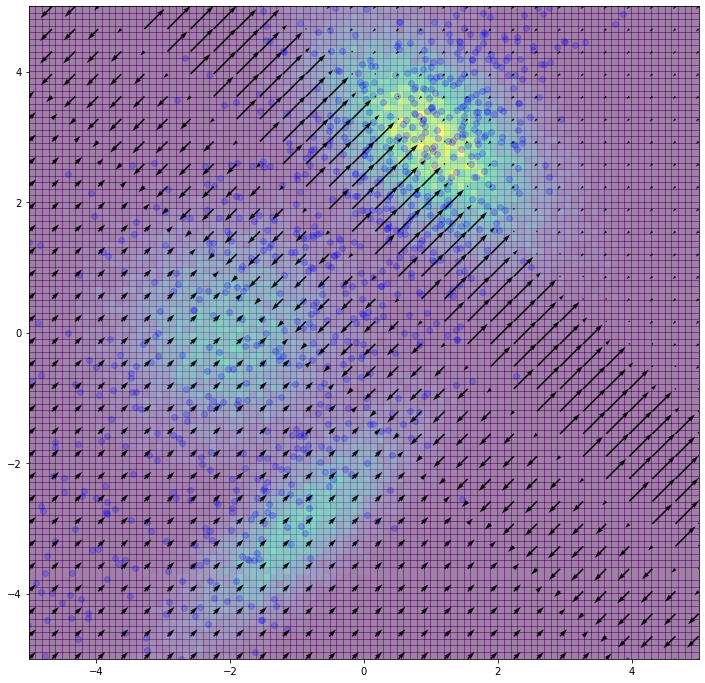

In [21]:
#!g1.1
from IPython import display

plt.xlim(lims)
plt.ylim(lims)

num_epochs = 100
batch_size = 64

# ===========================
# IMPORTANT PARAMETER:
# Number of D updates per G update
# ===========================
k_d, k_g = 4, 1

accs = []

try:
    for epoch in range(num_epochs):
        for input_data in iterate_minibatches(data, batch_size):
            
            # Optimize D
            for _ in range(k_d):
                # Sample noise
                noise = Variable(torch.Tensor(sample_noise(len(input_data))))
                
                # Do an update
                inp_data = Variable(torch.Tensor(input_data))
                data_gen = generator(noise)
                loss = d_loss(discriminator(data_gen), discriminator(inp_data))
                d_optimizer.zero_grad()
                loss.backward()
                d_optimizer.step()
                
                # Clip discriminator's weights
                for param in discriminator.parameters():
                    param.data.clamp_(-0.01, 0.01)
            
    
            # Optimize G
            for _ in range(k_g):
                # Sample noise
                noise = Variable(torch.Tensor(sample_noise(len(input_data))))
                
                # Do an update
                data_gen = generator(noise)
                loss = g_loss(discriminator(data_gen))
                g_optimizer.zero_grad()
                loss.backward()
                g_optimizer.step()
            
            # Visualize
            plt.clf()
            vis_data(data); vis_g(); vis_d()
            display.clear_output(wait=True)
            display.display(plt.gcf())

        
except KeyboardInterrupt:
    pass

#### TASK 4

In [22]:
#!g1.1
TASK = 4

In [23]:
#!g1.1
generator = Generator(NOISE_DIM, out_dim = 2)
discriminator = Discriminator(in_dim = 2)

lr = 0.001

g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [24]:
#!g1.1
# https://github.com/Zeleni9/pytorch-wgan/blob/master/models/wgan_gradient_penalty.py

import torch.autograd as autograd

LAMBDA=10

def calculate_gradient_penalty(real_image, fake_image):
    eta = torch.rand(real_image.shape[0], 1)
    eta = eta.expand(real_image.shape[0], real_image.shape[1])

    interpolated = eta * real_image + ((1 - eta) * fake_image)

    # define it to calculate gradient
    interpolated = Variable(interpolated, requires_grad=True)

    # calculate probability of interpolated examples
    prob_interpolated = discriminator(interpolated)

    # calculate gradients of probabilities with respect to examples
    gradients = autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                              grad_outputs=torch.ones(
                                  prob_interpolated.size()),
                              create_graph=True, retain_graph=True)[0]

    grad_penalty = LAMBDA * ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return grad_penalty

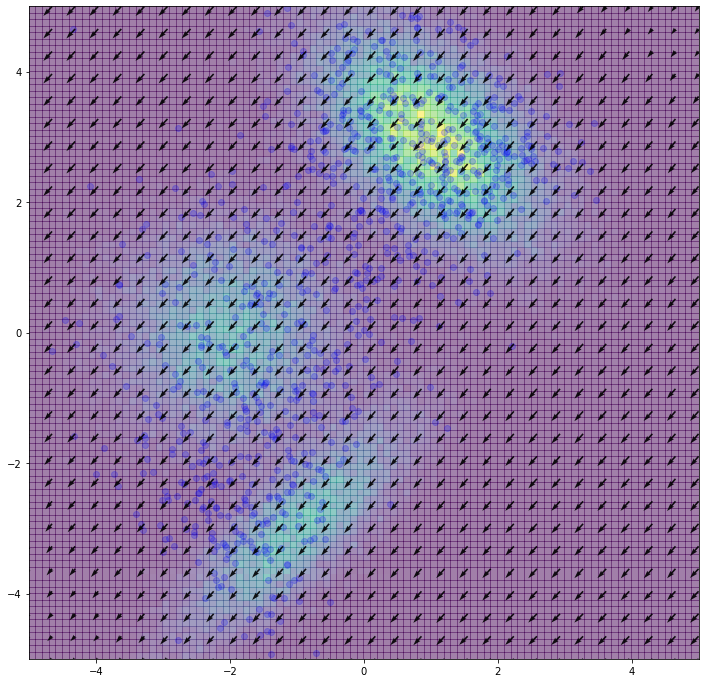

In [28]:
#!g1.1
from IPython import display

plt.xlim(lims)
plt.ylim(lims)

num_epochs = 100
batch_size = 64

# ===========================
# IMPORTANT PARAMETER:
# Number of D updates per G update
# ===========================
k_d, k_g = 4, 1

accs = []

try:
    for epoch in range(num_epochs):
        for input_data in iterate_minibatches(data, batch_size):
            
            # Optimize D
            for _ in range(k_d):
                # Sample noise
                noise = Variable(torch.Tensor(sample_noise(len(input_data))))
                
                # Do an update
                inp_data = Variable(torch.Tensor(input_data))
                data_gen = generator(noise)
                penalty = calculate_gradient_penalty(inp_data.data, data_gen.data)
                loss = d_loss(discriminator(data_gen), discriminator(inp_data), penalty)
                d_optimizer.zero_grad()
                loss.backward()
                d_optimizer.step()
            
    
            # Optimize G
            for _ in range(k_g):
                # Sample noise
                noise = Variable(torch.Tensor(sample_noise(len(input_data))))
                
                # Do an update
                data_gen = generator(noise)
                loss = g_loss(discriminator(data_gen))
                g_optimizer.zero_grad()
                loss.backward()
                g_optimizer.step()
            
            # Visualize
            plt.clf()
            vis_data(data); vis_g(); vis_d()
            display.clear_output(wait=True)
            display.display(plt.gcf())

        
except KeyboardInterrupt:
    pass

# Describe your findings here

1) В 1 и 2 пунктах сильных различий во время сходимости увидеть не удалось, они работают довольно похоже.   
2) Хуже всего была сходимость в 3 пункте, а вот в 4 сходимость к истинному распределению была довольно неплохой. Складывается ощущение, что сгенерированные данные пытаются сойтись к нормальному распределению (а не к смеси нормальных), поэтому данные похоже больше на эллипс, который не получается разделить. Такое отсутствует в 1 и 2 пунктах (на самом дела это можно увидеть, если посмотреть на направление градиентов).

Немного про 3 и 4 пункты.   
При выполнении данных пунктов были использованы статьи [раз](https://arxiv.org/pdf/1701.07875.pdf) и [два](https://arxiv.org/pdf/1704.00028.pdf). Я попробовала применить данные модели с дефолтными параметрами, как в статьях. В 3 пункте WGAN с weight clipping обучался с помощью оптимизатора RMSprop, причем его сходимость была очень плохой и изменение $lr$ не смогла повлиять на это. В 4 пункте обучался WGAN с добавкой gradient penalty к ошибке (код вычисления добавки был модифицирован [отсюда](https://github.com/Zeleni9/pytorch-wgan/blob/master/models/wgan_gradient_penalty.py)) с использованием оптимизатора Adam. Я пыталась менять параметры для оптимизатора, но при дефолтных параметров из статьи $beta_1 = 0, beta_2=0.9, lr=0.0001$ сходимость оказалась довольно плохой, поэтому я изменила данные параметры на те, которые были использованы при выполнении пунктов 1 и 2.